In [9]:
import numpy as np 
import matplotlib.pyplot as plt
import h5py

(50, 2, 40, 8, 40)
94.51404699832976
3200
0.173060388790887


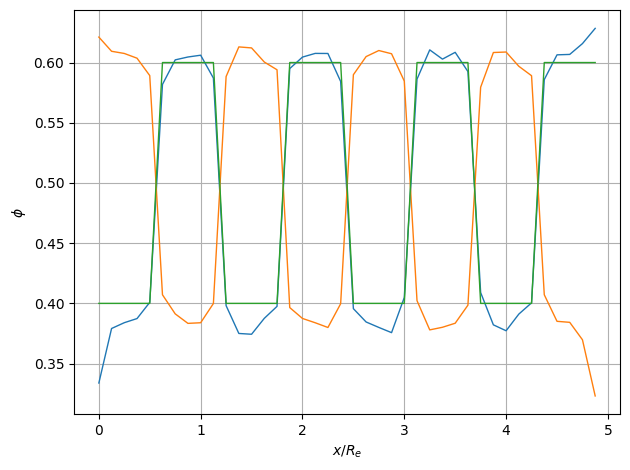

In [10]:
Nbars=[100]
dphi="dphi0.1"
offset=1 #to account for area51

plt.figure(dpi=100)
plt.grid()
y=0
for Nbar in Nbars:
    with h5py.File(f'{dphi}/Nbar{Nbar}/coord.h5', 'r') as f:
        ##number of beads per polymer
        N=int(f['parameter/reference_Nbeads'][()]) 
        #kappa
        kappa=30/N
        ##number of polymers
        n_polym=int(f['parameter/n_polymers'][()]) 
        n_poly_type=int(f['parameter/n_poly_type'][()]) 
        n_types=int(f['parameter/n_types'][()]) 
        ##box dimensions 
        lxyz=np.array(f['parameter/lxyz'])
        ##box discretization
        nxyz=np.array(f['parameter/nxyz'])
        #discretization
        dxyz=lxyz/nxyz
        #adjust lengths and discretizations
        lxyz=lxyz-2*offset*dxyz
        nxyz=nxyz-2*offset
        #umbrella field
        umb_field=np.array(f["umbrella_field"])
        #area51
        area51=np.array(f["area51"])
    with h5py.File(f'{dphi}/Nbar{Nbar}/coord_ana.h5', 'r') as f:
        #only load every other frame, the others are not optimized
        phi=np.array(f['density_field'])[1::2]
    #cell volume
    V_cell=np.prod(dxyz)
    #number of accessible cells 
    n_cells=int(len(area51[area51==0]))
    #field scaling type
    scale=n_cells/(N*n_polym)
    #reshape density and umbrella field
    phi=phi*scale
    phi=phi[:,:,area51==0].reshape(phi.shape[0],phi.shape[1],nxyz[0],nxyz[1],nxyz[2])
    umb_field=umb_field[umb_field>-1].reshape(2,nxyz[0],nxyz[2])
    #get composition
    phi_tot=np.sum(phi,axis=1)
    phi_tot[phi_tot==0]=1
    composition=phi
    for i in range(2):
        composition[:,i]=composition[:,i]/phi_tot
    print(composition.shape)
    #get phi at y value where umbrella field is defined
    phi_mean=phi[:,:,y,:].mean(axis=2)
    phi_tot=np.sum(phi_mean,axis=0)
    phi_tot[phi_tot==0]=1
    phi_mean[0]=phi_mean[0]/phi_tot
    phi_mean[1]=phi_mean[1]/phi_tot
    


    #volume
    V=V_cell*n_cells
    #average bead density
    rho0=N*Nbar
    #beads per cell
    rhoc=rho0*V_cell 
    #natural density fluctuations
    var_phi=1/(rho0*kappa*V_cell) 
    l_plot=np.arange(0,lxyz[0],dxyz[0])
    plt.xlabel("$x/R_e$")
    plt.ylabel("$\phi$")
    plt.plot(l_plot,composition.mean(axis=(0,4))[0,:,0],lw=1)
    plt.plot(l_plot,composition.mean(axis=(0,4))[1,:,0],lw=1)
    #plt.imshow(composition.mean(axis=(0))[0,:,0])
    #plt.imshow(umb_field[0])

    plt.plot(l_plot,umb_field[0,:,0],lw=1)
    L=0.0
    for x in range(nxyz[0]):
        for z in range(nxyz[2]):
            for j in range(2):
                L+=(composition[0,j,x,0,z]-umb_field[j,x,z])**2
    print(L)
    L=L/len(umb_field.flatten())
    print(len(umb_field.flatten()))
    print(L/var_phi)

plt.tight_layout()
plt.savefig(f"amplitude_sa_{dphi}_Nbar{Nbar}.pdf")


0.04277893388671875


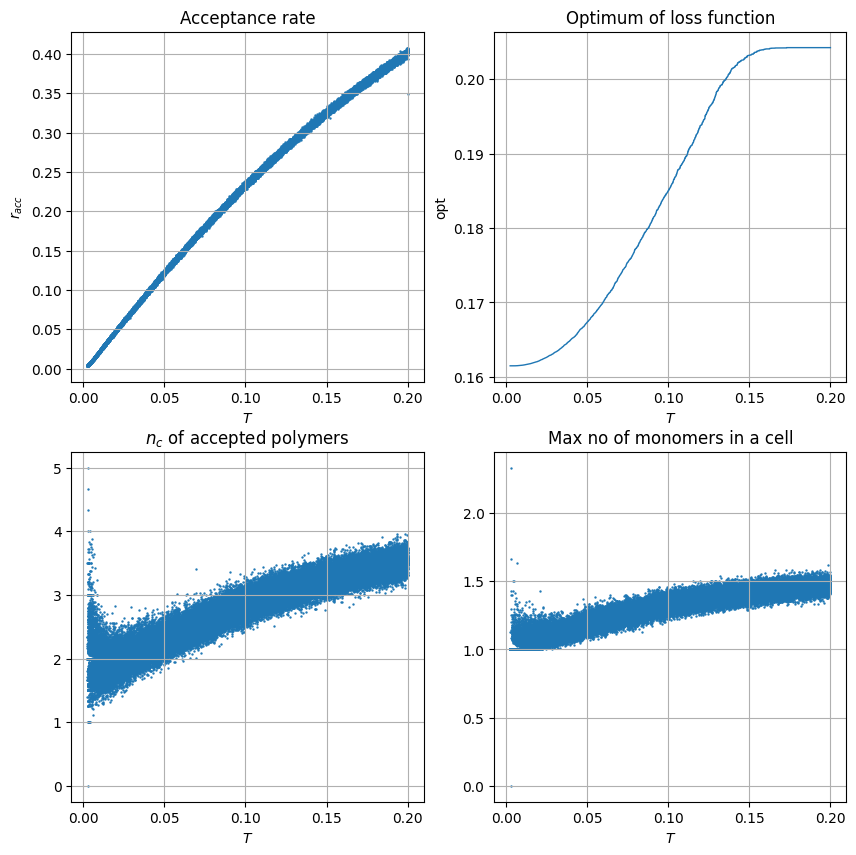

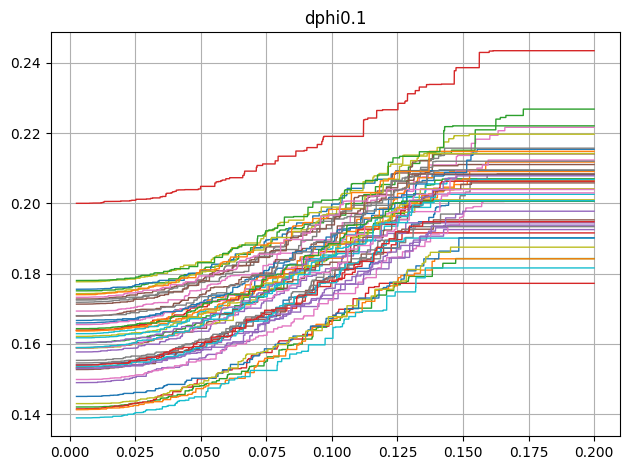

In [12]:

Nbars=[100]
#dphis=[0,0.1,0.2,0.3,0.4,0.5]
#dphis=[0.2,0.3,0.4,0.49]
#dphis=[0.1,0.2,0.3,0.4,0.49]
dphis=[0.1]


fig, axs = plt.subplots(2, 2, figsize=(10, 10),dpi=100)
axs=axs.flatten()
for i in range(len(axs)):
    axs[i].grid()

axs[0].set_title("Acceptance rate")
axs[1].set_title("Optimum of loss function")
axs[2].set_title("$n_c$ of accepted polymers")
axs[3].set_title("Max no of monomers in a cell")

axs[0].set_xlabel('$T$')
axs[1].set_xlabel('$T$')
axs[2].set_xlabel('$T$')
axs[3].set_xlabel('$T$')
axs[0].set_ylabel('$r_{acc}$')
axs[1].set_ylabel('opt')
#plt.yscale('log')
for Nbar in Nbars:
    for dphi in dphis:
        dphi="dphi"+str(dphi)
        with h5py.File(f'{dphi}/Nbar{Nbar}/coord.h5', 'r') as f:
            ##number of beads per polymer
            N=int(f['parameter/reference_Nbeads'][()]) 
            #kappa
            kappa=30/N
            ##number of polymers
            n_polym=int(f['parameter/n_polymers'][()]) 
            n_poly_type=int(f['parameter/n_poly_type'][()]) 
            n_types=int(f['parameter/n_types'][()]) 
            ##box dimensions 
            lxyz=np.array(f['parameter/lxyz'])
            ##box discretization
            nxyz=np.array(f['parameter/nxyz'])
            #discretization
            dxyz=lxyz/nxyz
            #adjust lengths and discretizations
            lxyz=lxyz-2*offset*dxyz
            nxyz=nxyz-2*offset
            #umbrella field
            umb_field=np.array(f["umbrella_field"])
            #area51
            area51=np.array(f["area51"])
            with h5py.File(f'{dphi}/Nbar{Nbar}/coord_ana.h5', 'r') as f:
                #only load every other frame, the others are not optimized
                phi=np.array(f['density_field'])
        #simulation time in MCS
        t =len(phi)
        #cell volume
        V_cell=np.prod(dxyz)
        #number of accessible cells 
        n_cells=int(len(area51[area51==0]))
        #number of target cells
        n_cells_target=len(umb_field[umb_field>-1])
        #field scaling type
        scale=n_cells/(N*n_polym)
        #phi=phi*scale
        #volume
        V=V_cell*n_cells
        #average bead density
        rho0=N*Nbar
        #beads per cell
        rhoc=rho0*V_cell 
        #natural density fluctuations
        var_phi=1/(rho0*kappa*V_cell) 
        T=np.loadtxt(f"{dphi}/Nbar{Nbar}/T.csv")
        T=T[:T.shape[0]//2]
        n_T=len(T)#number of temperatures
        opt=np.loadtxt(f"{dphi}/Nbar{Nbar}/opt.csv")/n_cells_target
        opt=opt.reshape(t,int(opt.shape[0]/t))[1::2]
        opt_mean=opt.mean(axis=0)
        opt_mean=opt_mean.reshape(n_T,int(opt_mean.shape[0]/n_T))
        acc_rate=np.loadtxt(f"{dphi}/Nbar{Nbar}/acc_rate.csv")#/n_cells_target
        acc_rate=acc_rate.reshape(t,int(acc_rate.shape[0]/t))[1::2].mean(axis=0)
        acc_rate=acc_rate.reshape(n_T,int(acc_rate.shape[0]/n_T))
        num_cells=np.loadtxt(f"{dphi}/Nbar{Nbar}/num_cells.csv")#/n_cells_target
        num_cells=num_cells[:num_cells.shape[0]//2]
        num_cells=num_cells.reshape(n_T,int(num_cells.shape[0]/n_T)).mean(axis=1)
        max_monos_cell=np.loadtxt(f"{dphi}/Nbar{Nbar}/max_monos_cell.csv")#/n_cells_target
        max_monos_cell=max_monos_cell[:max_monos_cell.shape[0]//2]
        max_monos_cell=max_monos_cell.reshape(n_T,int(max_monos_cell.shape[0]/n_T)).mean(axis=1)
        axs[0].scatter(T,acc_rate,s=0.5,label=r"$\rho_{cell}=$"+f"{rhoc}")
        axs[1].plot(T,opt_mean/var_phi,lw=1,label=dphi)
        print((np.max(opt_mean)-np.min(opt_mean))/var_phi)
        #axs[1].legend(loc='upper left')
        axs[2].scatter(T,num_cells,s=0.5)
        axs[3].scatter(T,max_monos_cell,s=0.5)
        plt.figure(dpi=100)
        plt.title(f"{dphi}")
        plt.grid()
        for i in range(len(opt)):
            opt_plot=opt[i]
            opt_plot=opt_plot.reshape(n_T,int(opt_mean.shape[0]/n_T))
            plt.plot(T,opt_plot/var_phi,lw=1)
#acc_rate=np.loadtxt(f"large_cells/acc_rate.csv")
#acc_rate=acc_rate.reshape(int(acc_rate.shape[0]/n_T),n_T).mean(axis=0)
#plt.plot(T,acc_rate,lw=1)
plt.tight_layout()



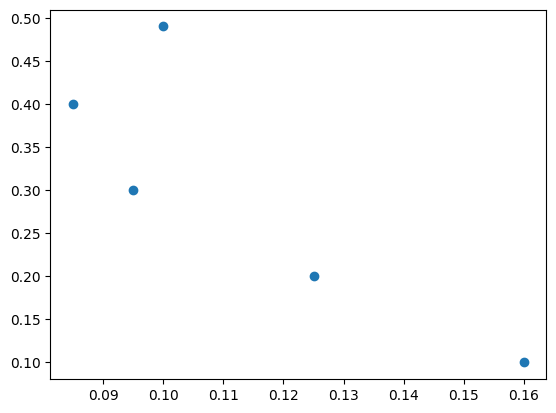

In [8]:
T_transition={0.1:0.16,0.2:0.125,0.3:0.095,0.4:0.085,0.49:0.1}
plt.scatter(T_transition.values(),T_transition.keys())